In [205]:
import pandas as pd
import streamlit as st
import unidecode
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("sales_data_sample.csv",encoding="latin1")

print(df.head(10))

   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   
5        10168               36      96.66                1  3479.76   
6        10180               29      86.13                9  2497.77   
7        10188               48     100.00                1  5512.32   
8        10201               22      98.57                2  2168.54   
9        10211               41     100.00               14  4708.44   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00

In [206]:
def view_nan(df):
    nan_count = df.isna().sum()
    nan_percent = (nan_count / len(df)) * 100
    nan_summary = pd.DataFrame({"NaN Count": nan_count, "NaN (%)": nan_percent})
    nan_summary = nan_summary[nan_summary["NaN Count"] > 0]
    nan_summary = nan_summary.sort_values(by="NaN (%)", ascending=False).round(1)
    return nan_summary

    

    

    
        
    
    

In [207]:
view_nan(df)

,NaN Count,NaN (%)
ADDRESSLINE2,2521,89.3
STATE,1486,52.6
TERRITORY,1074,38.0
POSTALCODE,76,2.7


In [208]:
def fill_nan(df, col="SALES", method="mean", fixed_value=None):
    df = df.copy()

    if isinstance(col, str):
        col = [col]

    for c in col:
        if c in df.columns:
            if method in ["mean", "median"] and pd.api.types.is_numeric_dtype(df[c]):
                if method == "mean":
                    df[c] = df[c].fillna(df[c].mean())
                elif method == "median":
                    df[c] = df[c].fillna(df[c].median())
            elif method == "mode":
                if not df[c].mode().empty:
                    df[c] = df[c].fillna(df[c].mode().iloc[0])
            elif method == "fixed" and fixed_value is not None:
                df[c] = df[c].fillna(fixed_value)

    return df

                

In [209]:
df_filled = fill_nan(df, col=["ADDRESSLINE2","TERRITORY"], method="mode", fixed_value=None)
df_filled.head()



,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,Level 3,NYC,NY,10022,USA,EMEA,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,Level 3,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,Level 3,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,Level 3,Pasadena,CA,90003,USA,EMEA,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,Level 3,San Francisco,CA,NaN,USA,EMEA,Brown,Julie,Medium


In [210]:
def remove_columns_with_many_nan(df, max_percent=80):
    limit = (max_percent / 100) * len(df)
    nan_counts = df.isna().sum()
    filter = nan_counts <= limit
    dropped_cols = nan_counts[~filter].index.tolist()
    print("Removed Columns: (Higher than {}% NaN):".format(max_percent))
    print(dropped_cols)
    return df.loc[:, filter]
    


In [211]:
df_filtered = remove_columns_with_many_nan(df, max_percent=80)
df_filtered.head(5)

Removed Columns: (Higher than 80% NaN):
['ADDRESSLINE2']


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,PHONE,ADDRESSLINE1,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,2125557818,897 Long Airport Avenue,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,26.47.1555,59 rue de l'Abbaye,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,6265557265,78934 Hillside Dr.,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,6505551386,7734 Strong St.,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [212]:
def padronize_data_types(df):
    expected_types = {
        "ORDERNUMBER": "Int64",
        "QUANTITYORDERED": "Int64",
        "PRICEEACH": "float",
        "ORDERLINENUMBER": "Int64",
        "SALES": "float",
        "ORDERDATE": "datetime64[ns]",
        "STATUS": "category",
        "QTR_ID": "Int64",
        "MONTH_ID": "Int64",
        "YEAR_ID": "Int64",
        "PRODUCTLINE": "category",
        "MSRP": "float",
        "PRODUCTCODE": "string",
        "CUSTOMERNAME": "string",
        "PHONE": "string",
        "ADDRESSLINE1": "string",
        "ADDRESSLINE2": "string",
        "CITY": "string",
        "STATE": "string",
        "POSTALCODE": "string",
        "COUNTRY": "string",
        "TERRITORY": "string",
        "CONTACTLASTNAME": "string",
        "CONTACTFIRSTNAME": "string",
        "DEALSIZE": "category",
    }
    converted_cols = []
    for key, dtype in expected_types.items():
        if key in df.columns:
            try:
                if dtype.lower().startswith("int"):
                    df[key] = pd.to_numeric(df[key], errors="coerce").astype(dtype)
                elif dtype == "float":
                    df[key] = pd.to_numeric(df[key], errors="coerce").astype(dtype)
                elif dtype == "datetime64[ns]":
                    df[key] = pd.to_datetime(df[key], errors="coerce")
                else:
                    df[key] = df[key].astype(dtype)
                converted_cols.append(key)
            except Exception as e:
                print(f"Error trying to convert {key}: {e}")
    print("Converted Columns:", converted_cols)
    return df


In [213]:
df_temp = padronize_data_types(df)
df_temp.head(10)

Converted Columns: ['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE', 'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE', 'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'DEALSIZE']


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,897 Long Airport Avenue,<NA>,NYC,NY,10022,USA,<NA>,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,59 rue de l'Abbaye,<NA>,Reims,<NA>,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,<NA>,Paris,<NA>,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,78934 Hillside Dr.,<NA>,Pasadena,CA,90003,USA,<NA>,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,7734 Strong St.,<NA>,San Francisco,CA,<NA>,USA,<NA>,Brown,Julie,Medium
5,10168,36,96.66,1,3479.76,2003-10-28,Shipped,4,10,2003,...,9408 Furth Circle,<NA>,Burlingame,CA,94217,USA,<NA>,Hirano,Juri,Medium
6,10180,29,86.13,9,2497.77,2003-11-11,Shipped,4,11,2003,...,"184, chausse de Tournai",<NA>,Lille,<NA>,59000,France,EMEA,Rance,Martine,Small
7,10188,48,100.00,1,5512.32,2003-11-18,Shipped,4,11,2003,...,"Drammen 121, PR 744 Sentrum",<NA>,Bergen,<NA>,N 5804,Norway,EMEA,Oeztan,Veysel,Medium
8,10201,22,98.57,2,2168.54,2003-12-01,Shipped,4,12,2003,...,5557 North Pendale Street,<NA>,San Francisco,CA,<NA>,USA,<NA>,Murphy,Julie,Small
9,10211,41,100.00,14,4708.44,2004-01-15,Shipped,1,1,2004,...,"25, rue Lauriston",<NA>,Paris,<NA>,75016,France,EMEA,Perrier,Dominique,Medium


In [214]:
def remove_and_check_duplicates(df,subset=None):
    df = df.copy()
    duplicates_count = df.duplicated(subset=subset).sum()
    if duplicates_count > 0:
        print(f"{duplicates_count} duplicated rows found and removed")
        df = df.drop_duplicates(subset=subset)
    return df    


In [215]:
duplicated = remove_and_check_duplicates(df,subset=None)
duplicated.head(5)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,897 Long Airport Avenue,<NA>,NYC,NY,10022,USA,<NA>,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,59 rue de l'Abbaye,<NA>,Reims,<NA>,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,<NA>,Paris,<NA>,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,78934 Hillside Dr.,<NA>,Pasadena,CA,90003,USA,<NA>,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,7734 Strong St.,<NA>,San Francisco,CA,<NA>,USA,<NA>,Brown,Julie,Medium


In [216]:
def check_invalid_business_value(df, cols=None):
    def check_invalid_business_values(df, cols=None):

     df = df.copy()
    if not cols:
        cols = ["QUANTITYORDERED", "PRICEEACH", "SALES"]
    if isinstance(cols, str):
        cols = [cols]
    if "QUANTITYORDERED" in cols and "QUANTITYORDERED" in df.columns:
        neg_qty = (df["QUANTITYORDERED"] < 0).sum()
        if neg_qty > 0:
            print(f"{neg_qty} rows with negative QUANTITYORDERED found and removed")
            df = df[df["QUANTITYORDERED"] > 0]
    if "PRICEEACH" in cols and "PRICEEACH" in df.columns:
        price_zero = (df["PRICEEACH"] <= 0).sum()
        if price_zero > 0:
            print(f"{price_zero} rows with PRICEEACH <= 0 found and removed")
            df = df[df["PRICEEACH"] > 0]
    if "SALES" in cols and "SALES" in df.columns:
        sales_zero = (df["SALES"] <= 0).sum()
        if sales_zero > 0:
            print(f"{sales_zero} rows with SALES <= 0 found and removed")
            df = df[df["SALES"] > 0]
    return df

    
    

In [217]:
bussines_values = check_invalid_business_value(df, cols=None)
bussines_values.head(5)

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,897 Long Airport Avenue,<NA>,NYC,NY,10022,USA,<NA>,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,59 rue de l'Abbaye,<NA>,Reims,<NA>,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,<NA>,Paris,<NA>,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,78934 Hillside Dr.,<NA>,Pasadena,CA,90003,USA,<NA>,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,7734 Strong St.,<NA>,San Francisco,CA,<NA>,USA,<NA>,Brown,Julie,Medium


In [218]:
def check_outliers_zscore(df, cols, limit=5):
   
    df = df.copy()
    if isinstance(cols, str):
        cols = [cols]
    for col in cols:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            z = (df[col] - df[col].mean()) / df[col].std()
            outliers = df[abs(z) > limit]
            outlier_count = len(outliers)
            if outlier_count > 0:
                print(f"{outlier_count} outliers detected in {col} (Z > {limit}) and removed")
                df = df[abs(z) <= limit]
    return df

In [219]:
outliers = check_outliers_zscore(df, cols=["QUANTITYORDERED","SALES"], limit=5)

2 outliers detected in QUANTITYORDERED (Z > 5) and removed
1 outliers detected in SALES (Z > 5) and removed


In [220]:
def check_sales_consistency(df):
    df = df.copy()
    if set(["QUANTITYORDERED", "PRICEEACH", "SALES"]).issubset(df.columns):
        inconsistent = abs(df["QUANTITYORDERED"] * df["PRICEEACH"] - df["SALES"]) > 1e-2
        inconsistency_count = inconsistent.sum()
        if inconsistency_count > 0:
            print(f"{inconsistency_count} rows where SALES != QUANTITYORDERED * PRICEEACH found and removed")
            df = df[~inconsistent]
    return df

In [221]:
sales_consistency = check_sales_consistency(df)
print(sales_consistency.head(5))

1304 rows where SALES != QUANTITYORDERED * PRICEEACH found and removed
   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
5        10168               36      96.66                1  3479.76   

   ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0 2003-02-24  Shipped       1         2     2003  ...   
1 2003-05-07  Shipped       2         5     2003  ...   
2 2003-07-01  Shipped       3         7     2003  ...   
3 2003-08-25  Shipped       3         8     2003  ...   
5 2003-10-28  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2        CITY STATE POSTALCODE  \
0        897 Long Airport Avenue          <NA>         NYC    NY      1002

In [222]:
import unidecode
def cleaning_strings(df, cols):
    df = df.copy()
    if isinstance(cols, str):
        cols = [cols]
    for col in cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.lower().map(unidecode.unidecode)
    return df

In [223]:
clean_string = cleaning_strings(df, cols=["CUSTOMERNAME","CITY","COUNTRY","CONTACTLASTNAME","CONTACTFIRSTNAME"])
print(clean_string.head(5))

   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

   ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0 2003-02-24  Shipped       1         2     2003  ...   
1 2003-05-07  Shipped       2         5     2003  ...   
2 2003-07-01  Shipped       3         7     2003  ...   
3 2003-08-25  Shipped       3         8     2003  ...   
4 2003-10-10  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue          <NA>            nyc    NY   
1             59 rue de l'Abbaye          <NA>          reims  <NA>   
2  27 rue d

In [224]:
def check_phone_format(df, cols="PHONE"):
    
    df = df.copy()
    if isinstance(cols, str):
        cols = [cols]
    for col in cols:
        if col in df.columns:
            invalid = ~df[col].astype(str).str.match(r"^\+?\d[\d -]{7,}$")
            count = invalid.sum()
            if count > 0:
                print(f"{count} invalid phone numbers in {col} removed")
                df = df[~invalid]
    return df

In [225]:
phone_checked = check_phone_format(df, cols="PHONE")
print(phone_checked.head(5))

870 invalid phone numbers in PHONE removed
   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   
5        10168               36      96.66                1  3479.76   

   ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0 2003-02-24  Shipped       1         2     2003  ...   
2 2003-07-01  Shipped       3         7     2003  ...   
3 2003-08-25  Shipped       3         8     2003  ...   
4 2003-10-10  Shipped       4        10     2003  ...   
5 2003-10-28  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue          <NA>            NYC    NY   
2  27 rue du Colonel Pierre Avia       

In [226]:
def check_date_consistency(df):
    df = df.copy()
    if set(["ORDERDATE", "YEAR_ID", "MONTH_ID", "QTR_ID"]).issubset(df.columns):
        df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")
        invalid_dates = df["ORDERDATE"].isna().sum()
        if invalid_dates > 0:
            print(f"{invalid_dates} rows have invalid ORDERDATE values and were removed")
            df = df[~df["ORDERDATE"].isna()]
        order_year = df["ORDERDATE"].dt.year
        order_month = df["ORDERDATE"].dt.month
        order_quarter = (order_month - 1) // 3 + 1
        year_mismatch = order_year != df["YEAR_ID"]
        month_mismatch = order_month != df["MONTH_ID"]
        qtr_mismatch = order_quarter != df["QTR_ID"]
        if year_mismatch.sum() > 0:
            print(f"{year_mismatch.sum()} rows with YEAR_ID different from ORDERDATE year removed")
            df = df[~year_mismatch]
        if month_mismatch.sum() > 0:
            print(f"{month_mismatch.sum()} rows with MONTH_ID different from ORDERDATE month removed")
            df = df[~month_mismatch]
        if qtr_mismatch.sum() > 0:
            print(f"{qtr_mismatch.sum()} rows with QTR_ID different from ORDERDATE quarter removed")
            df = df[~qtr_mismatch]
    return df


In [227]:
data_checked = check_date_consistency(df)
print(data_checked.head(5))

   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

   ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0 2003-02-24  Shipped       1         2     2003  ...   
1 2003-05-07  Shipped       2         5     2003  ...   
2 2003-07-01  Shipped       3         7     2003  ...   
3 2003-08-25  Shipped       3         8     2003  ...   
4 2003-10-10  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue          <NA>            NYC    NY   
1             59 rue de l'Abbaye          <NA>          Reims  <NA>   
2  27 rue d

In [228]:
def plot_top_clients(df, n=5):
    top_clients = df.groupby("CUSTOMERNAME")["SALES"].sum().sort_values(ascending=False).head(n)
    print(f"Top {n} clients")
    fig, ax = plt.subplots()
    sns.barplot(x=top_clients.values, y=top_clients.index, ax=ax)
    ax.set_xlabel("Total Sales")
    ax.set_ylabel("Client")
    plt.show()

Top 10 clients


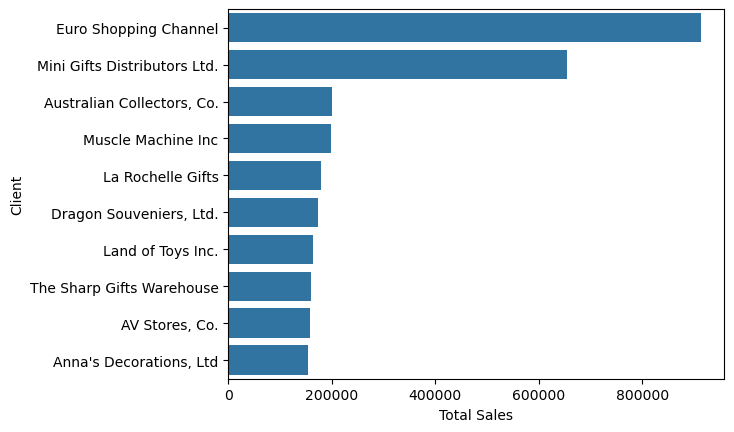

In [229]:
plot_top_clients(df, n=10)

In [230]:
def plot_top_months(df,n=5):
    if "ORDERDATE" in df.columns:
        df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"],errors="coerce")
        df["YEAR_MONTH"] = df["ORDERDATE"].dt.strftime('%Y-%m')
        top_months = df.groupby("YEAR_MONTH")["SALES"].sum().sort_values(ascending=False).head(n)
        print(f"Top {n} months with highest sales")
        fig, ax = plt.subplots()
        sns.barplot(x=top_months.values,y=top_months.index,ax=ax)
        ax.set_xlabel("Total Sales")
        ax.set_ylabel("Year - Month")
        st.pyplot(fig)
    else:
        print("Column ORDERDATE not found")    


Top 10 months with highest sales


2025-09-13 14:40:11.609 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-13 14:40:11.652 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-13 14:40:11.652 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-13 14:40:11.653 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


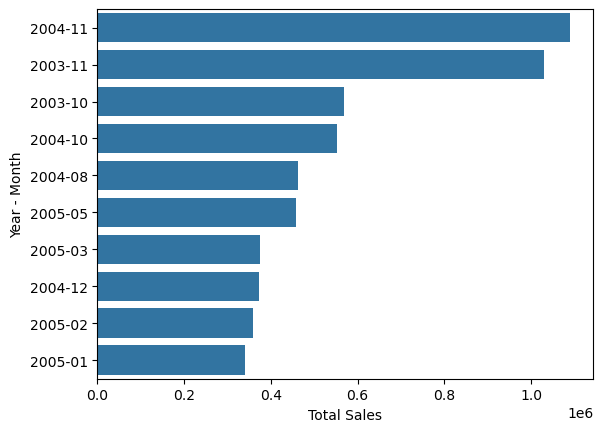

In [231]:
plot_top_months(df,n=10)

In [232]:
def plot_top_products(df, n=5):
    top_products = df.groupby("PRODUCTCODE")["QUANTITYORDERED"].sum().sort_values(ascending=False).head(n)
    print(f"Top {n} produtos mais vendidos")
    fig, ax = plt.subplots()
    sns.barplot(x=top_products.values, y=top_products.index, ax=ax)
    ax.set_xlabel("Quantity Sold")
    ax.set_ylabel("Product")
    plt.show()


Top 10 produtos mais vendidos


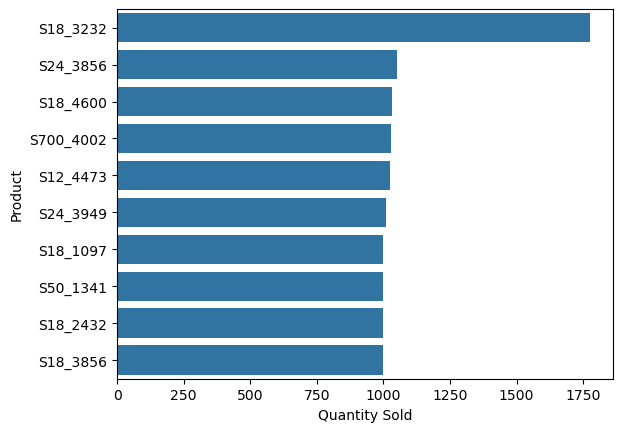

In [233]:
plot_top_products(df,n=10)

In [234]:
def plot_inactive_clients(df, reference_month=None):
    df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")
    last_date = df["ORDERDATE"].max()
    if reference_month is None:
        reference_month = last_date.strftime("%Y-%m")
    active_clients = set(df[df["ORDERDATE"].dt.strftime("%Y-%m") == reference_month]["CUSTOMERNAME"])
    all_clients = set(df["CUSTOMERNAME"].unique())
    inactive_clients = all_clients - active_clients
    inactive_df = pd.DataFrame(sorted(list(inactive_clients)), columns=["Inactive Clients"])
    print(f"Clients who did not buy in {reference_month}:")
    display(inactive_df.reset_index(drop=True).head(10))


In [235]:
plot_inactive_clients(df,reference_month="2004-05")

Clients who did not buy in 2004-05:


,Inactive Clients
0,"AV Stores, Co."
1,Alpha Cognac
2,Amica Models & Co.
3,"Anna's Decorations, Ltd"
4,Atelier graphique
5,"Australian Collectables, Ltd"
6,"Australian Collectors, Co."
7,"Australian Gift Network, Co"
8,Auto Assoc. & Cie.
9,Auto-Moto Classics Inc.


In [239]:
def plot_top_countries(df, n=5):
    if "COUNTRY" in df.columns:
        top_countries = df.groupby("COUNTRY")["SALES"].sum().sort_values(ascending=False).head(n)
        st.write(f"Top {n} countries")
        fig, ax = plt.subplots()
        sns.barplot(x=top_countries.values, y=top_countries.index, ax=ax)
        ax.set_xlabel("Total sales")
        ax.set_ylabel("Country")
        plt.show()
    else:
        print("Column country not found")

2025-09-13 14:42:58.316 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-13 14:42:58.316 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-13 14:42:58.316 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


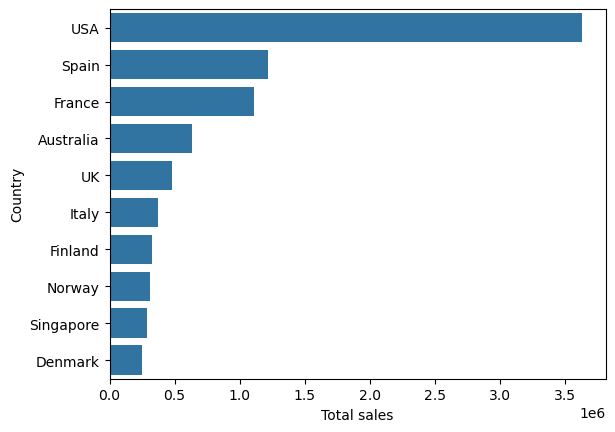

In [241]:
plot_top_countries(df,n=10)

In [253]:
def plot_sales_trend(df, freq="M"):
    df["ORDERDATE"] = pd.to_datetime(df["ORDERDATE"], errors="coerce")
    sales = df.groupby(pd.Grouper(key="ORDERDATE", freq=freq))["SALES"].sum().reset_index()
    st.write("Sales tendency throughout the years")
    fig, ax = plt.subplots()
    sns.lineplot(x="ORDERDATE", y="SALES", data=sales, ax=ax, marker="o")
    ax.set_xlabel("Data")
    ax.set_ylabel("Total sales")
    plt.xticks(rotation=45)
    plt.show(fig)

/tmp/ipykernel_3669/1915547215.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  sales = df.groupby(pd.Grouper(key="ORDERDATE", freq=freq))["SALES"].sum().reset_index()
2025-09-13 15:29:55.499 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-13 15:29:55.499 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-13 15:29:55.500 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-13 15:29:55.499 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-13 15:29:55.500 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


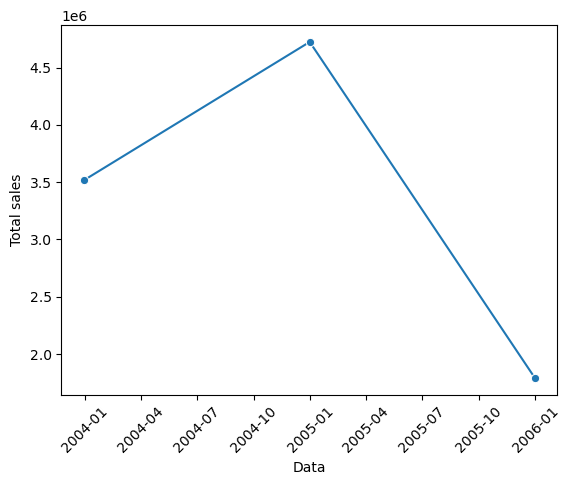

In [256]:
plot_sales_trend(df,freq="Y")          # D for day / W for week / M for month/ Q for quarter / Y for year